Training Data

In [ ]:
import pandas as pd

weather_df = pd.read_csv('../fit/weather_sdc_eu.csv')
weather_df = weather_df[weather_df['region'].isin(['Lombardia','Thüringen'])]
covid_df = pd.read_csv('../fit/covid_sdc_eu.csv')
covid_df = covid_df[covid_df['region'].isin(['Lombardia','Thüringen'])]
df = (covid_df.merge(weather_df, on=['date','region'])
             .drop(columns=['Unnamed: 0_x','Unnamed: 0_y', 'variable', 'iso3'])
             .assign(Active = lambda x: x.confirmed - (x.recovered + x.deaths))
             .rename(columns={"date":"Date", "confirmed":"Confirmed", "deaths":"Deaths", "recovered":"Recovered", "new_cases":"NewCases", "value":"temperature"})
)

thu_df = df[df['region'] == 'Thüringen'].drop(columns='region')
lom_df = df[df['region'] == 'Lombardia'].drop(columns='region')

thu_df.to_csv('../fit/thuringen_data.csv',index=False)
lom_df.to_csv('../data/process_based_model/training_data/LombardiaData.csv',index=False)

Fitting

C:\Users\brand\AppData\Local\Temp\ipykernel_12888\1440973735.py:325: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ini=int(np.where(pd.to_datetime(Data.Date) == np.datetime64(datetime.datetime(2022, 6, 1)))[0])


Optimziation:  1  of  10
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.0900e+01                                    4.81e+01    
       1              2         9.1256e+00      1.18e+01       3.38e-01       3.69e+01    
       2              3         3.4083e-01      8.78e+00       1.85e-01       9.39e+01    
       3              4         8.0745e-02      2.60e-01       1.32e-01       1.40e+01    
       4              5         2.2115e-02      5.86e-02       1.20e-01       1.35e+00    
       5              6         1.4490e-02      7.63e-03       1.22e-01       9.29e-01    
       6              7         3.4131e-03      1.11e-02       1.29e-01       1.25e-01    
       7              8         2.7519e-03      6.61e-04       3.74e-02       6.03e-03    
       8             10         2.6875e-03      6.44e-05       7.03e-02       3.15e-02    
       9             11         2.5297e-03      1.58e-04       2.

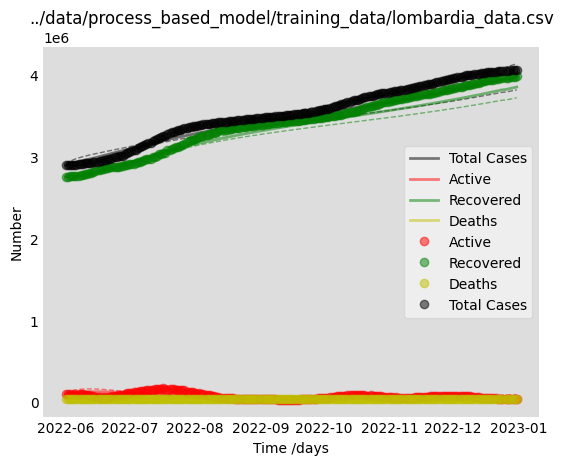

In [7]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Fri Dec 11 10:27:20 2020

@author: leonardo
"""
"""
Modelo estocástico COVID-19
versión estocàstica del modelo compartimental de NHB y RINP
Las probabilidades son deducidas a paritir de las tasas 
Poblaciones:
    - S: Suceptibles
    - E: Expuestos
    - I: Infectados
    - R: Recuperados
    - D: Muertos
    - Y: Casos totales
Parametros:
     * alpha: confination rate
     * beta: infection rate
     * gamma: incubation rate
     * delta: detected infected 
     * Lambda: recovery rate
     * kappa: death rate
     * tau:  deconfination rate
"""
import numpy as np
import math
import pandas as pd
#import pythran
import matplotlib.pyplot as plt
from lmfit import minimize, Parameters, Parameter, report_fit, Model, Minimizer
import math as m
from scipy import interpolate
from sklearn.metrics import mean_squared_error 
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import datetime

# np.random.seed(123)
#


def T_inv(T,timeT):

    T=pd.concat([T,T])
    That = savgol_filter(T, 51, 3) # window size 51, polynomial order 3

    pos=timeT[ini].day+30*timeT[ini].month-30
    Tinv=1-T/np.mean(T)+1.5
    Tinv=Tinv[pos:len(Tinv)-1]
    
    Tinvhat=1-That/np.mean(That)+1.5
    Tinvhat=Tinvhat[pos:len(Tinvhat)-1]
    
    t=np.arange(len(Tinv))
  
    Tinv=Tinvhat

    return [t,Tinv]

#------------------------------------------------------------------------------
#                       Diference equation system
#               This can be formulated from the ODE system
#               Return a column vector with the system at time t
#------------------------------------------------------------------------------
def SEIQRDP(t, y, ps):   
    delta   = ps['delta'].value
    alpha  = ps['alpha0'].value*m.exp(-ps['alpha1'].value*t)
    betQ    = ps['betaQ'].value
    bet     = ps['beta'].value
    gamma   = ps['gamma'].value
    Lambda = ps['lambda0'].value*(1.-m.exp(-ps['lambda1'].value*t))
    kappa = ps['kappa0'].value*m.exp(-ps['kappa1'].value*t)    
    tau    = ps['tau0'].value*(1.-m.exp(-ps['tau1'].value*t))
    rho = 0
    N=Npop

    S,E,I,Q,R,D,P,V=y
    if S<0:
        S=0
    if E<0:
        E=0
    if I<0:
        I=0
    if Q<0:
        Q=0
    if R<0:
        R=0
    if D<0:
        D=0
    if P<0:
        P=0
    if V<0:
        V=0
    beta= (1/N)*(bet*I + betQ*Q)
    efrac =   (1.0 - m.exp(-beta*dt))        #|exposedexposed prob
    ifrac =   (1.0 - m.exp(-gamma*dt))       #|infection prob
    rfrac =   (1.0 - m.exp(-Lambda*dt))      #|recov prob
    pfrac =   (1.0 - m.exp(-alpha*dt))       #|protec prob
    dfrac =   (1.0 - m.exp(-kappa*dt))       #|death prob
    relfrac = (1.0 - m.exp(-tau*dt))         #|release prob
    repfrac = (1.0 - m.exp(-delta*dt))       #|detected prob
    vacfrac = (1.0 - m.exp(-rho*dt))       #|detected prob
    
#    --------------------------------------------
    exposed =  np.random.binomial(S,efrac)
    protected = np.random.binomial(S,pfrac)
    
    infection = np.random.binomial(E,ifrac)    
    detected = np.random.binomial(I,repfrac)

    recovery = np.random.binomial(Q,rfrac)
    deaths = np.random.binomial(Q,dfrac)

    released  = np.random.binomial(P,relfrac)
    vaccinated  = np.random.binomial(S,vacfrac)
#    ------------------------------------------
    S = S - exposed - protected + released - vaccinated     #| Susceptible
    E = E + exposed - infection                             #| Exposed
    I = I + infection - detected                            #| Infected 
    Q = Q + detected - recovery - deaths                    #| Detected
    R = R + recovery                                        #| Recovered
    D = D + deaths                                          #| Deaths
    P = P + protected - released                            #| Protected
    V = V + vaccinated                                       #| Total Cases
#    ------------------------------------------
    return [S,E,I,Q,R,D,P,V]

#------------------------------------------------------------------------------
#                       Simulation function
#               Return a matrix with the dynamic of each population
#------------------------------------------------------------------------------
def simulate(t,u,ps): 
#    np.random.seed(int(ps['seed'].value))
    S = np.zeros(len(t))
    E = np.zeros(len(t))
    I = np.zeros(len(t))
    Q = np.zeros(len(t))
    R = np.zeros(len(t))
    D = np.zeros(len(t))
    P = np.zeros(len(t))
    Y = np.zeros(len(t))
    for j in range(len(t)):
        u = SEIQRDP(t[j],u,ps)
        S[j],E[j],I[j],Q[j],R[j],D[j],P[j],Y[j] = u
    return  {'t':t,'S':S,'E':E,'I':I,'Q':Q,'R':R,'D':D,'P':P,'V':Y}
#------------------------------------------------------------------------------
#                       Simulation function N times
#               Return a matrix with the mean dynamic of each population 
#------------------------------------------------------------------------------
def  simulate_N_times(t, u, ps):
#    np.random.seed(int(ps['seed'].value))
    times=100
    S=np.zeros([times,len(t)])
    E=np.zeros([times,len(t)])
    I=np.zeros([times,len(t)])
    Q=np.zeros([times,len(t)])
    R=np.zeros([times,len(t)])
    D=np.zeros([times,len(t)])
    P=np.zeros([times,len(t)])
    Z=np.zeros([times,len(t)])
    vec=np.zeros(len(t))
    Y={'t':t,'S':vec,'E':vec,'I':vec,'Q':vec,'R':vec,'D':vec,'P':vec,'V':vec}
    for i in np.arange(times):
        y = simulate(t, u, ps)
        S[i,:]=y['S']
        E[i,:]=y['E']
        I[i,:]=y['I']
        Q[i,:]=y['Q']
        R[i,:]=y['R']
        D[i,:]=y['D']
        P[i,:]=y['P']
        Z[i,:]=y['Y']

    Y['S']=S.mean(0)
    Y['E']=E.mean(0)
    Y['I']=I.mean(0)
    Y['Q']=Q.mean(0)
    Y['R']=R.mean(0)
    Y['D']=D.mean(0)
    Y['P']=P.mean(0)
    Y['Y']=Z.mean(0)
#    
    return Y


#------------------------------------------------------------------------------
#                       Interpolation function
#              Single interpolation of 1 vector
#               
#------------------------------------------------------------------------------

def interpolation(y,t,ti):
    f= interpolate.interp1d(t,y, kind='nearest')
    f2 =f(ti)
    return f2
#------------------------------------------------------------------------------




#------------------------------------------------------------------------------
#                       Interpolation function
#              Single interpolation of 1 vector
#               
#------------------------------------------------------------------------------

def Sys_interpolation(Y,t,ti):
    col=Y.columns
    
    datcol=col[1:len(col)]
    Yinterp={}
    Yinterp['t']=ti
    for i in datcol:
#        print(Y[str(i)])
        yi=Y[str(i)].to_numpy()
        f2=interpolation(yi,t,ti)
        Yinterp[str(i)]=f2

    return Yinterp
#------------------------------------------------------------------------------
    


#------------------------------------------------------------------------------
#                       DETERMINISTIC MODEL
#              Definition of the model in deterministic way
#              For fitting propouse
#------------------------------------------------------------------------------

def COVID_SEIRC(y,t,ps):
    
#    try:
    alpha0=ps['alpha0'].value
    alpha1=ps['alpha1'].value
    bet=ps['beta'].value
    betQ=ps['betaQ'].value
    gam=ps['gamma'].value
    delt=ps['delta'].value
    lamda0=ps['lambda0'].value
    lamda1=ps['lambda1'].value
    kappa0=ps['kappa0'].value
    kappa1=ps['kappa1'].value
    tau0=ps['tau0'].value
    tau1=ps['tau1'].value
    # rho= ps['rho'].value
    rho=0
    S,E,I,Q,R,D,C,V=y
#    ______________parameters____________________________
    alpha = lambda t: alpha0*m.exp(-alpha1*t)
    beta=lambda t:bet
    betaQ=lambda t:betQ
    gamma=gam
    delta=delt
    Lambda = lambda t: lamda0*(1.-m.exp(-lamda1*t))
    kappa = lambda t: kappa0*m.exp(-kappa1*t)
    tau= lambda t: tau0*(1.-m.exp(-tau1*t))
    
    BETA=(beta(t)*I+betaQ(t)*Q)*1/Npop
#    ___________equations___________________________________
    dS = tau(t)*C - alpha(t)*S- BETA*S - rho*S
    dE = -gamma*E + BETA*S
    dI = gamma*E - delta*I
    dQ = delta*I - Lambda(t)*Q - kappa(t)*Q
    dR = Lambda(t)*Q
    dD = kappa(t)*Q
    dC = alpha(t)*S - tau(t)*C
    dV = rho*S
    return dS,dE,dI,dQ,dR,dD,dC,dV
#==============================================================================
#                   INRTEGRATION FUNCTION
#==============================================================================
    
def g(t, y0, ps):
    """
    Solution to the ODE x'(t) = f(t,x,k) with initial condition x(0) = x0
    """
    x = odeint(COVID_SEIRC, y0, t, args=(ps,))
    return x
#==============================================================================
        
#==============================================================================
def residual(ps,ts,data):
    model = g(ts, y0opt, ps)
    Q=model[:,3]
    R=model[:,4]
    D=model[:,5]
    Inf=((Q - data[0,:])/Npop).ravel()
    Rec=((R - data[1,:])/Npop).ravel()
    Dea=((D - data[2,:])/Npop).ravel()
    resid=np.array([Inf,Rec,Dea])
    return resid
#==============================================================================
def residual2(ps,ts,data):
    model = g(ts, y0opt, ps)
    Q=model[:,3]
    R=model[:,4]
    D=model[:,5]
    TC=Q+R+D
    Inf=((Q - data[0,:])/Npop).ravel()
    Rec=((R - data[1,:])/Npop).ravel()
    Dea=((D - data[2,:])/Npop).ravel()
    Tot=((TC - data[3,:])/Npop).ravel()
    resid=np.array([Inf,Rec,Dea,Tot])
    return resid
#==============================================================================
#------------------------------------------------------------------------------
#                   The main code begins from here    
#------------------------------------------------------------------------------

#===============================LOAD DATA FROM FILES===========================

#----------------------------- Lombardía -------------------------------------#
nombredearchivo_csv='../data/process_based_model/training_data/LombardiaData.csv'
Data = pd.read_csv(open(nombredearchivo_csv), sep=",").fillna(0)
Npop=10060574
#   First wave
#ini=0
#fin=int(np.where(pd.to_datetime(Data.Date) == np.datetime64(datetime.datetime(2022, 5, 31)))[0])

#   Second wave
ini=int(np.where(pd.to_datetime(Data.Date) == np.datetime64(datetime.datetime(2022, 6, 1)))[0])  
fin=len(Data) 


#--------------------------- Thuringen ---------------------------------------#
#nombredearchivo_csv='Clean Data/ThuringenData.csv'
#Data = pd.read_csv(open(nombredearchivo_csv), sep=",").fillna(0)
#Npop=2392000
#   First wave
# ini=Data.NewCases[Data.Active>=10].index[0]
# fin=int(np.where(pd.to_datetime(Data.Date) == np.datetime64(datetime.datetime(2020, 7, 28)))[0])

#   Second wave
#ini=int(np.where(pd.to_datetime(Data.Date) == np.datetime64(datetime.datetime(2020, 9, 27)))[0])  
#fin=len(Data)
#------------------------------- Catalunya -----------------------------------#
# nombredearchivo_csv='Clean Data/CatalunyaData.csv'
# Data = pd.read_csv(open(nombredearchivo_csv), sep=",").fillna(0)
# Npop=7780479
#   First wave
# ini=Data.NewCases[Data.Active>=10].index[0]
# fin=int(np.where(pd.to_datetime(Data.Date) == np.datetime64(datetime.datetime(2020, 5, 15)))[0]) 
#   Second wave
# ini=int(np.where(pd.to_datetime(Data.Date) == np.datetime64(datetime.datetime(2020, 5, 16)))[0])  
# fin=int(np.where(pd.to_datetime(Data.Date) == np.datetime64(datetime.datetime(2020, 10, 1)))[0])

#   Third wave
# ini=int(np.where(pd.to_datetime(Data.Date) == np.datetime64(datetime.datetime(2020, 10, 2)))[0]) 
# fin=len(Data)
# -----------------------------------------------------------------------------


time=pd.to_datetime(Data.Date)
Active=  Data.Active

time = pd.to_datetime(Data.Date[ini:fin])

Confirmed =  Data.Confirmed[ini:fin]
NewCases =  Data.NewCases[ini:fin]
Recovered =  Data.Recovered[ini:fin]
Deaths =  Data.Deaths[ini:fin]
Active = Data.Active[ini:fin]




# temperature Data
T=Data.temperature
timeT= pd.to_datetime(Data.Date)
tb,Beta=T_inv(T,timeT)

f = interp1d(tb, Beta, kind='cubic')

DataM=np.array([Active,Recovered,Deaths,Confirmed])

E0 = Active[ini]
I0 = Active[ini]
Q0 = Active[ini]
R0 = Recovered[ini]
D0 = Deaths[ini]
P0 = 0
V0 = 0
S0 = Npop-E0-I0-Q0-R0-D0-P0-V0

Iter=10
Outputs=list()
FullSetOptParam=list()
for i in np.arange(Iter):
    print('Optimziation: ',i+1,' of ',Iter)
    #===============SETING THE ORIGIAL SET OF PARAMETERS===========================
    lb=0
    ub=1
    params = Parameters()
    params.add('alpha0', value=np.random.uniform(0,0.03), min=0, max=1)
    params.add('alpha1', value=np.random.uniform(0,0.3), min=0, max=1)
    params.add('beta', value= np.random.uniform(1,2), min=0, max=3)
    params.add('betaQ', value= params['beta'].value*.2, min=0, max=params['beta'].value*.3)
    params.add('gamma', value= np.random.uniform(0,0.5), min=0, max=1)
    params.add('delta', value= np.random.uniform(0,0.3), min=0, max=1)
    params.add('lambda0', value= np.random.uniform(0,0.3), min=0, max=1)
    params.add('lambda1', value= np.random.uniform(0,0.03), min=0, max=1)
    params.add('kappa0', value=np.random.uniform(0,0.003), min=0, max=1)
    params.add('kappa1', value= np.random.uniform(0,0.3), min=0, max=1)
    params.add('tau0', value= np.random.uniform(0,0.3), min=0, max=1)
    params.add('tau1', value= np.random.uniform(0,0.03), min=0, max=1)
    
    N=Npop
    dt=1/24
    
    y0 = [S0,E0,I0,Q0,R0,D0,P0,V0]
    y0opt =S0,E0,I0,Q0,R0,D0,P0,V0
    
    tf = len(time)
    tl = int(tf/dt)
    t = np.linspace(0,tf-1,tl)
    topt= np.linspace(1, len(time), len(time))
    sol = minimize(residual, params, args=(topt,DataM),method='least_squares',max_nfev=500,
                        ftol=1e-6,gtol=1e-6,xtol=1e-6,loss='linear',diff_step=1e-5,verbose=2,tr_solver='lsmr')
    paropt=sol.params
    print(report_fit(sol))
    FullSetOptParam.append(paropt)
   
    sir_out = pd.DataFrame(simulate(t, y0, paropt))

    ti= np.linspace(t[0],t[len(t)-1],int(t[len(t)-1]-t[0])+1)
    sir_out = pd.DataFrame(Sys_interpolation(sir_out,t,ti))
    Outputs.append(sir_out)

Results=np.array(Outputs)
vector=Results.mean(axis=0)
std=Results.std(axis=0)
t,s,e,i,q,r,d,p,v= std.transpose()
t,S,E,I,Q,R,D,P,V= vector.transpose()

TC=Q+R+D
tc=q+r+d
#-------------------------------------------------------------------------
# Plot Reult
fig = plt.figure(1,facecolor='w')
ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.plot(time, TC-tc, '--k', alpha=0.5, lw=1)  
ax.plot(time, TC, 'k', alpha=0.5, lw=2, label='Total Cases')
ax.plot(time, TC+tc, '--k', alpha=0.5, lw=1)

                      
ax.plot(time, Q-q, '--r', alpha=0.5, lw=1)  
ax.plot(time, Q, 'r', alpha=0.5, lw=2, label='Active')
ax.plot(time, Q+q, '--r', alpha=0.5, lw=1)  

ax.plot(time, R-r, '--g', alpha=0.5, lw=1)  
ax.plot(time, R, 'g', alpha=0.5, lw=2, label='Recovered')
ax.plot(time, R+r, '--g', alpha=0.5, lw=1)  

ax.plot(time, D-d, '--y', alpha=0.5, lw=1)  
ax.plot(time, D, 'y', alpha=0.5, lw=2, label='Deaths')
ax.plot(time, D+d, '--y', alpha=0.5, lw=1)  

ax.plot(time,Active, 'or', alpha=0.5, lw=2, label='Active')
ax.plot(time,Recovered, 'og', alpha=0.5, lw=2, label='Recovered')
ax.plot(time,Deaths, 'oy', alpha=0.5, lw=2, label='Deaths')
ax.plot(time,Confirmed, 'ok', alpha=0.5, lw=2, label='Total Cases')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
#ax.grid(b=True, which='major', c='w', lw=2, ls='-')
titulo=nombredearchivo_csv.replace('Clean Data/', '')
titulo=titulo.replace('Data.csv', '')

ax.set_title(titulo)

legend = ax.legend()
legend.get_frame().set_alpha(0.5)
   
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)

plt.show()

Results

In [11]:
df = pd.DataFrame({
    'Date': time,
    'S': S,
    'E': E,
    'I': I,
    'Q': Q,
    'R': R,
    'D': D,
    'P': P,
    'Total Cases': D + Q + R,
    'std S': s,
    'std E': e,
    'std I': i,
    'std Q': q,
    'std R': r,
    'std D': d,
    'std P': p,
    'std Total Cases': d + q + r,
    'N': Npop
})

In [13]:
df.to_csv('../data/process_based_model/pre_optimized_results/Lombardia_2_constant')

In [8]:
import pickle
file_path = '../data/process_based_model/parameters/constant/Lombardia2.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(FullSetOptParam[5], file)